In [ ]:
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from config import CONFIG
sys.path.insert(1, str(CONFIG.src))
sys.path.insert(2, str(CONFIG.utils))

from utilities import \
(get_accuracy, visualize_losses, BaseModel, Matrix, Vector, get_numpy_instance)

# import logging
# from logger import LOGGER


class Distiller(keras.Model):

    def __init__(self, teacher, student) -> None:
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn,
                    distillation_loss_fn, alpha: float = 0.1, temperature: int = 3) -> None:
        """Configure the distiller

        Args:
            optimizer (_type_): Keras optimzer for the student weights
            metrics (_type_): Keras metrics for evaluation
            student_loss_fn (_type_): Loss function of difference between student predictions and ground-truth
            distillation_loss_fn (_type_): Loss function of difference between soft student predictions and soft teacher predictions
            alpha (float, optional): weight to student_loss_fn and 1 - alpha to distillation_loss_fn. Defaults to 0.1.
            temperature (int, optional): Temperature for softening probability distributions. Larger temperature gives softer distributions. Defaults to 3.
        """

        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        #Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training = True)
            
            # Compute loss
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1)
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({
            "student_loss": student_loss, "distillation_loss": distillation_loss
        })

        return results

    def test_step(self, data):
        # Unpack data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performacne
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    
teacher = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
    layers.Flatten(),
    layers.Dense(10),
], name="teacher",
)

student = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.Flatten(),
    layers.Dense(10),
    
], name="student"
)


In [ ]:


# LOGGER.info("Load and prepare data...")
student_scratch = keras.models.clone_model(student)

# Prepare the dataset
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# LOGGER.info("Train teacher...")
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
teacher_history = teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)
# LOGGER.info("End train and test teacher model.")
# LOGGER.info("Distill the teacher to student")
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# student_distiller_history = distiller.fit(x_train, y_train, epochs=3)
# distiller.evaluate(x_test, y_test)
# # LOGGER.info("End train and test knowledge distillation")
# # LOGGER.info("Train student from scratch for comparison")
# student_scratch.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

In [4]:
import pickle
teacher_path = r"D:\personal_projects\bluemethodllc\txnguyenblue\reports\knowledge_distillation_keras\teacherHistory"
student_distill_path = r"D:\personal_projects\bluemethodllc\txnguyenblue\reports\knowledge_distillation_keras\student_distill"
student = r"D:\personal_projects\bluemethodllc\txnguyenblue\reports\knowledge_distillation_keras\student"
def load_pickle(file_path: str):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

teacher_history = load_pickle(teacher_path)
student_distiller_history = load_pickle(student_distill_path)
student_history = load_pickle(student)



NonGuiException: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

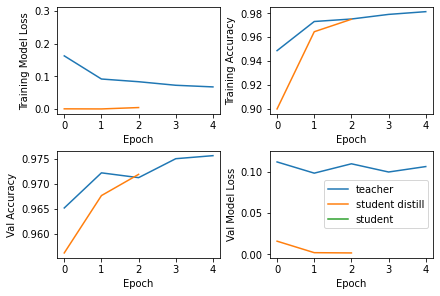

In [10]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True)
ax1.plot(teacher_history["loss"], label="teacher")
ax1.plot(student_distiller_history["student_loss"], label="student distill")
ax1.plot(student_history["loss"], label="student")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Model Loss")
# ax2.legend(["teacher", "student distilled", "student"], loc="upper left")
ax2.plot(teacher_history["sparse_categorical_accuracy"])
ax2.plot(student_distiller_history["sparse_categorical_accuracy"])
ax2.plot(student_history["sparse_categorical_accuracy"])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Training Accuracy")
ax4.plot(teacher_history["val_loss"], label="teacher")
ax4.plot(student_distiller_history["val_student_loss"], label="student distill")
ax4.plot(student_history["val_loss"], label="student")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Val Model Loss")
ax3.plot(teacher_history["val_sparse_categorical_accuracy"], label="teacher")
ax3.plot(student_distiller_history["val_sparse_categorical_accuracy"], label="student distill")
ax3.plot(student_history["val_sparse_categorical_accuracy"], label="student")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Val Accuracy")
plt.legend()
# plt.subplot_tool()
plt.tight_layout()

In [7]:
student_history

{'loss': [0.2974509298801422],
 'sparse_categorical_accuracy': [0.9114406108856201],
 'val_loss': [0.11982012540102005],
 'val_sparse_categorical_accuracy': [0.9638907313346863]}